# Recurrent Neural Networks

We now look at a new architecture to build our models. Previous models such as the CNN or Fully connected layers did not take into account a "sequence" or list of ordered inputs. In applications like NLP, the input (a sentence or a list of words) almost always has a sequential importance. This is why we need a way to incorporate that sequence while training our models.

This is done with the help of RNNs or Recurrent Neural Networks. A vanilla RNN would take the previous hidden state, pass it along with the input to the next hidden state. It should be noted that our inputs are no longer single data rows but a sequence of datarows all bunched together and passed together. There are 3 most common type of RNNs:
1. Vanilla RNNs (for lack of better wording)
2. LSTMs (RNNs with better long term memory)
3. GRUs (Similar functioning to LSTM but lesser operations per cell)

Vanilla RNNs are bad at learning long sequences. This is because of the "vanishing gradient problem". The longer the sequence, the more the effect and worse the effect on the lower layers. This is overcome by Long Short Term Memory (LSTM) cells which use gates and cell states to forget/update and output new states and outputs.Gated Recurrent Units (GRUs) are similar to LSTMs but they use lesser gates thus being quicker than LSTMs. 

In this notebook, i will be training a GRU on the IMDB reviews dataset and compare it to the fully connected model built in previous notebook.

In [1]:
import numpy as np
import pandas as pd
import os


from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, Dataset
from pymagnitude import Magnitude

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

In [2]:
ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR,"data")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(ROOT_DIR,device)

%matplotlib inline

D:\PROJECTS\Github\nlp-basics cuda


In [3]:
df = pd.read_csv(os.path.join(DATA_DIR,"imdb_reviews.csv"))
df.head()

,review,label
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [4]:
words = df.review[0].split()
len(words)

168

In [5]:
class Sequences(Dataset):
    def __init__(self,path,seqLen):
        
        self.seqLen = seqLen
        df = pd.read_csv(path)
        
        vectorizer = CountVectorizer(stop_words='english', min_df=0.015)
        vectorizer.fit(df.review.tolist())
        
        # All words in our vocab and their indices...
        self.token2idx = vectorizer.vocabulary_
        self.token2idx['<PAD>'] = max(self.token2idx.values()) + 1
        
        
        tokenizer = vectorizer.build_analyzer()
        
        
        #find the index corresponding to all words in a sentence...
        self.encode = lambda sent: [self.token2idx[token] for token in tokenizer(sent) if token in self.token2idx]
        
        
        # Pad the list of words with our "<PAD>" variable...
        self.pad = lambda x: x + (seqLen - len(x)) * [self.token2idx['<PAD>']]
        
        
        # Encode all reviews in the df...
        sequences = [self.encode(sent)[:seqLen] for sent in df.review.tolist()]
        
        #zip input and label lists together and unpack them...
        sequences, self.labels = zip(*[(sequence, label) for sequence, label 
                                       in zip(sequences, df.label.tolist()) if sequence])
        
        
        #pad the sequences...
        self.sequences = [self.pad(sequence) for sequence in sequences]


        
    def __getitem__(self,i):
        assert len(self.sequences) == len(self.labels)
        return self.sequences[i],self.labels[i]
        
    def __len__(self):
        return len(self.sequences)        

In [6]:
dataset = Sequences(os.path.join(DATA_DIR,"imdb_reviews.csv"), seqLen = 128)

In [7]:
# Each review has some arbitrary number of words and 50 output dimensions and there are ~62k such reviews...
print(len(dataset.sequences))
gloveEmb = Magnitude(os.path.join(ROOT_DIR,"embeddings","glove-lemmatized.6B.50d.magnitude"))

def collate(batch):
    inputs=[]
    target=[]
    for item in batch:
        tmp = gloveEmb.query(item[0])
        inputs.append(tmp)
        target.append(item[1])
    
    inputs = torch.FloatTensor(inputs).cuda()
    target = torch.FloatTensor(target).cuda()

    return inputs, target

batch_size = 1024
train_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate)

62155


In [8]:
class RecModel(nn.Module):
    
    def __init__(self, batchSize, vocabSize, embDims,
                 hiddenSize=128, nLayers=1, device='cuda'):
        
        
        super(RecModel,self).__init__()
        
        self.nLayers = nLayers
        self.hiddenSize = hiddenSize
        self.device = device
        self.batchSize = batchSize
        
#                       
        #self.encoder = nn.Embedding(vocabSize, embDims)
#                           
        self.rnn = nn.GRU(embDims, hiddenSize,
            num_layers=nLayers, batch_first=True,)
#                               
        self.decoder = nn.Linear(hiddenSize, 1)
        
    
    def init_hidden(self):
        A=torch.empty(self.nLayers, self.batchSize, self.hiddenSize).to(self.device)
        torch.nn.init.kaiming_normal_(A, a=0, mode='fan_in', nonlinearity='relu')
        return A
        
    
    def forward(self,inputs):
        
        batchSize = inputs.size(0)
        
        if batchSize != self.batchSize:
            self.batchSize = batchSize
            
        #encoded = self.encoder(inputs)
        
        output, hidden = self.rnn(inputs, self.init_hidden())
        output = self.decoder(output[:, :, -1]).squeeze()
        
        return output

In [9]:
device='cuda'
model = RecModel(batchSize=1024,vocabSize=1104,embDims=50,hiddenSize=128,nLayers=2)
model = model.to(device)
model

RecModel(
  (rnn): GRU(50, 128, num_layers=2, batch_first=True)
  (decoder): Linear(in_features=128, out_features=1, bias=True)
)

In [10]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.003)

In [11]:
model.train()
train_losses = []

for epoch in range(3):

    progress_bar = tqdm_notebook(train_loader, leave=False)
    losses = []
    total = 0
    
    for inputs, target in progress_bar:
        model.zero_grad()
        
        output = model(inputs)
    
        loss = criterion(output, target)
        
        loss.backward()
              
        nn.utils.clip_grad_norm_(model.parameters(), 3)

        optimizer.step()
        
        progress_bar.set_description(f'Loss: {loss.item():.3f}')
        
        losses.append(loss.item())
        total += 1
    
    epoch_loss = sum(losses) / total
    train_losses.append(epoch_loss)

    tqdm.write(f'Epoch #{epoch + 1}    Train Loss: {epoch_loss:.3f}')

Epoch #1    Train Loss: 1.098


Epoch #2    Train Loss: 0.704


Epoch #3    Train Loss: 0.696


[1.0975606264088487, 0.7044911521380065, 0.6955554543948564]


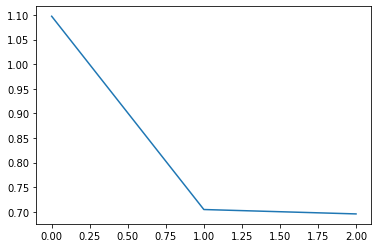

In [17]:
print(train_losses)
plt.plot(train_losses)

In [15]:
def predict_sentiment(text):
    model.eval()
    with torch.no_grad():
        
        words = 
        tmp = gloveEmb.query(words)
        test_vector = torch.LongTensor([dataset.pad(dataset.encode(text))]).to(device)
        
        output = model(test_vector)
        prediction = torch.sigmoid(output).item()

        if prediction > 0.5:
            print(f'{prediction:0.3}: Positive sentiment')
        else:
            print(f'{prediction:0.3}: Negative sentiment')

In [16]:
test_text = """
Don't let any bullies out there try and shape your judgment on this gem of a
title.

Some people really don't have anything better to do, except trash a great movie
with annoying 1-star votes and spread lies on the Internet about how "dumb"
Cool Cat is.

I wouldn't be surprised to learn if much of the unwarranted negativity hurled
at this movie is coming from people who haven't even watched this movie for
themselves in the first place. Those people are no worse than the Butch the
Bully, the film's repulsive antagonist.

As it just so happens, one of the main points of "Cool Cat Saves the Kids" is
in addressing the attitudes of mean naysayers who try to demean others who
strive to bring good attitudes and fun vibes into people's lives. The message
to be learned here is that if one is friendly and good to others, the world is
friendly and good to one in return, and that is cool. Conversely, if one is
miserable and leaving 1-star votes on IMDb, one is alone and doesn't have any
friends at all. Ain't that the truth?

The world has uncovered a great, new, young filmmaking talent in "Cool Cat"
creator Derek Savage, and I sure hope that this is only the first of many
amazing films and stories that the world has yet to appreciate.

If you are a cool person who likes to have lots of fun, I guarantee that this
is a movie with charm that will uplift your spirits and reaffirm your positive
attitudes towards life.
"""
predict_sentiment(test_text)

NameError: name 'item' is not defined

In [ ]:
got = """They stole Jon Snow's destiny in this episode. 
Jon was always written to fight against the white walkers. 
To have someone else steal the kill shot from him, just to fit in with 2019 political agenda is disgusting. 
I've been waiting for this for over 20 years. 
This is not what was promised. 
The battle scene was completely stupid as well. 
Walls are meant to be hidden behind or mounted upon. 
Hopefully they haven't neutered GRRM as they did D&D. 
Ever since the show runners took over the story this show has been total crap."""

predict_sentiment(got)